# LAB | Ensemble Methods

**Load the data**

In this challenge, we will be working with the same Spaceship Titanic data, like the previous Lab. The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

In this Lab, you should try different ensemble methods in order to see if can obtain a better model than before. In order to do a fair comparison, you should perform the same feature scaling, engineering applied in previous Lab.

In [8]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [9]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Now perform the same as before:
- Feature Scaling
- Feature Selection

In [10]:
spaceship.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [12]:
spaceship.dropna(inplace = True)
spaceship['Cabin'] = spaceship['Cabin'].str.split('/').str[0]
spaceship['Cabin'].value_counts()

Cabin
F    2152
G    1973
E     683
B     628
C     587
D     374
A     207
T       2
Name: count, dtype: int64

In [13]:
# Drop passengerId and name

spaceship = spaceship.drop(columns=['PassengerId','Name'])


In [14]:
# - For non-numerical columns, do dummies.

spaceship = pd.get_dummies(spaceship, columns=['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Transported'], drop_first=True)


**Perform Train Test Split**

In [15]:
X = spaceship.drop('Transported_True', axis=1)
y = spaceship['Transported_True']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5284, 19) (1322, 19) (5284,) (1322,)


**Model Selection** - now you will try to apply different ensemble methods in order to get a better model

- Bagging and Pasting

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns


In [22]:
# Crear un clasificador de árbol de decisión
base_model = DecisionTreeClassifier()

# Crear un modelo de Bagging
bagging_model = BaggingClassifier(estimator=base_model, n_estimators=50, random_state=42)

# Entrenar el modelo de Bagging
bagging_model.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = bagging_model.predict(X_test)

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo de Bagging: {accuracy:.2f}')

Precisión del modelo de Bagging: 0.81


In [19]:
# Crear un modelo de Pasting 
pasting_model = BaggingClassifier(estimator=base_model, n_estimators=50, bootstrap=False, random_state=42)

# Entrenar el modelo de Pasting
pasting_model.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred_pasting = pasting_model.predict(X_test)

# Calcular la precisión
accuracy_pasting = accuracy_score(y_test, y_pred_pasting)
print(f'Precisión del modelo de Pasting: {accuracy_pasting:.2f}')

Precisión del modelo de Pasting: 0.75


- Random Forests

In [24]:
# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
modelo_rf.fit(X_train, y_train)

# Hacer predicciones
y_pred = modelo_rf.predict(X_test)

# Calcular la precisión
precision = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo de Random Forest: {precision:.2f}')

Precisión del modelo de Random Forest: 0.80


- Gradient Boosting

In [27]:
# Crear el modelo de Gradient Boosting
modelo_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Entrenar el modelo
modelo_gb.fit(X_train, y_train)

# Hacer predicciones
y_pred = modelo_gb.predict(X_test)

# Calcular la precisión
precision = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo de Gradient Boosting: {precision:.2f}')

Precisión del modelo de Gradient Boosting: 0.81


- Adaptive Boosting

In [33]:
# Crear el clasificador débil (árbol de decisión)
base_model = DecisionTreeClassifier(max_depth=1)

# Crear el modelo de AdaBoost
adaboost_model = AdaBoostClassifier(estimator=base_model, n_estimators=50, random_state=42)

# Entrenar el modelo
adaboost_model.fit(X_train, y_train)

# Hacer predicciones
y_pred = adaboost_model.predict(X_test)

# Calcular la precisión
precision = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo de AdaBoost: {precision:.2f}')

c:\Users\eslab\anaconda3\envs\env_test\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Precisión del modelo de AdaBoost: 0.79


Which model is the best and why?

c:\Users\eslab\anaconda3\envs\env_test\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


                   Accuracy  F1 Score
Random Forest      0.807867  0.807863
AdaBoost           0.791982  0.791629
Gradient Boosting  0.808623  0.808137
Bagging            0.722390  0.716493
Pasting            0.722390  0.716493


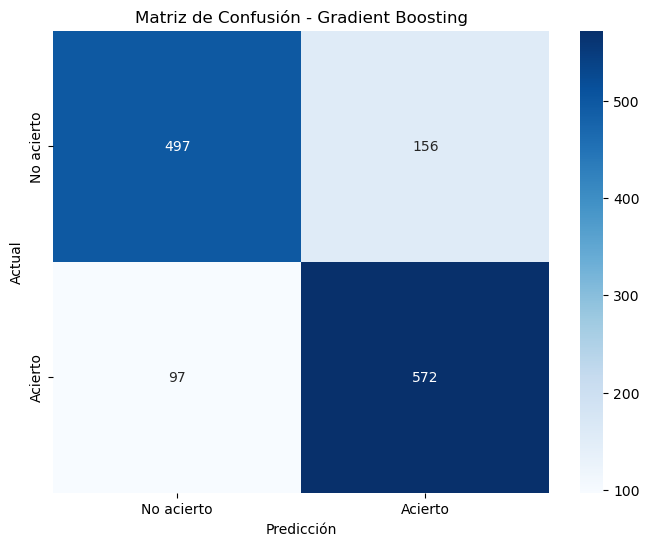

In [41]:
# Inicializar los modelos
models = {
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, random_state=42),
    'Bagging': BaggingClassifier(estimator=base_model, n_estimators=50, random_state=42),
    'Pasting': BaggingClassifier(estimator=base_model, n_estimators=50, bootstrap=False, random_state=42)
}

# Evaluar los modelos
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Para clasificación multiclase
    results[name] = {'Accuracy': accuracy, 'F1 Score': f1}

# Convertir los resultados en un DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

# Visualizar la matriz de confusión para el mejor modelo
best_model_name = results_df['Accuracy'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No acierto', 'Acierto'], 
            yticklabels=['No acierto', 'Acierto'])  
plt.ylabel('Actual')
plt.xlabel('Predicción')
plt.title(f'Matriz de Confusión - {best_model_name}')
plt.show()







